In [2]:
# The code was removed by Watson Studio for sharing.

# Location evaluation for Gastronomy Businesses based on Geospatial Data

In [3]:
import requests
import lxml.html as lh
import pandas as pd
import re
import numpy as np

# Data Collection

Read economic data broken down by zip from census data bank

In [4]:
url="https://www2.census.gov/programs-surveys/cbp/datasets/2017/zbp17totals.zip"
df_census=pd.read_csv(url)
df_census.head()

,zip,name,empflag,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,city,stabbr,cty_name
0,1001,"AGAWAM, MA",NaN,G,9891,G,96616,G,422470,473,AGAWAM,MA,HAMPDEN
1,1002,"AMHERST, MA",NaN,H,8482,H,70277,H,299103,545,AMHERST,MA,HAMPSHIRE
2,1003,"AMHERST, MA",NaN,G,337,H,2461,H,10380,21,AMHERST,MA,HAMPSHIRE
3,1004,"AMHERST, MA",NaN,H,213,H,1422,H,5912,12,AMHERST,MA,HAMPSHIRE
4,1005,"BARRE, MA",NaN,H,1248,H,8163,H,35287,94,BARRE,MA,WORCESTER


In [5]:
df_census.shape

(35279, 13)

Read geospatial data for the zip of the US

In [308]:
url="https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B"
df_geo_data=pd.read_csv(url, sep=";")
df_geo_data.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.39398,-6,1,"34.398483,-94.39398"
1,72044,Edgemont,AR,35.624351,-92.16056,-6,1,"35.624351,-92.16056"
2,56171,Sherburn,MN,43.660847,-94.74357,-6,1,"43.660847,-94.74357"
3,49430,Lamont,MI,43.010337,-85.89754,-5,1,"43.010337,-85.89754"
4,52585,Richland,IA,41.194129,-91.98027,-6,1,"41.194129,-91.98027"


df_census_major_city includes the zip's of the 5 largest cities of the US and the coressponding econimical data

In [309]:
df_geo_data_reduced=df_geo_data.drop(columns={'City', 'State', 'Timezone','Daylight savings time flag','geopoint'})
df_geo_data_reduced.rename(columns={'Zip':'zip'}, inplace=True)
df_geo_data_reduced.head()

,zip,Latitude,Longitude
0,71937,34.398483,-94.39398
1,72044,35.624351,-92.16056
2,56171,43.660847,-94.74357
3,49430,43.010337,-85.89754
4,52585,41.194129,-91.98027


Merge economical and geodata into the dataframe df_census_merged

In [8]:
df_census_merged=df_census.merge(df_geo_data_reduced, on='zip')
df_census_merged.shape

(34976, 15)

df_census_merged combinines goedata and economical data for the postal codes in the US

In [9]:
df_census_merged.head()

,zip,name,empflag,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,city,stabbr,cty_name,Latitude,Longitude
0,1001,"AGAWAM, MA",NaN,G,9891,G,96616,G,422470,473,AGAWAM,MA,HAMPDEN,42.070610,-72.620290
1,1002,"AMHERST, MA",NaN,H,8482,H,70277,H,299103,545,AMHERST,MA,HAMPSHIRE,42.377651,-72.503230
2,1003,"AMHERST, MA",NaN,G,337,H,2461,H,10380,21,AMHERST,MA,HAMPSHIRE,42.369562,-72.635990
3,1004,"AMHERST, MA",NaN,H,213,H,1422,H,5912,12,AMHERST,MA,HAMPSHIRE,42.384494,-72.513183
4,1005,"BARRE, MA",NaN,H,1248,H,8163,H,35287,94,BARRE,MA,WORCESTER,42.412094,-72.104430


save the dataframe df_census_merged

In [45]:
df_census_merged=df_census.merge(df_geo_data_reduced, on='zip')
df_census_merged.shape
project.save_data("df_census_merged_US.csv", df_census_merged.to_csv(index=False), overwrite=True)

{'file_name': 'df_census_merged_US.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstone-donotdelete-pr-lrmdwfeelnvzph',
 'asset_id': '1a13c7d5-24c7-4c32-a7e0-a4ecdf4b4d62'}

## use the Foursquare API to get the venues in located in the zips of interest

In [10]:
# The code was removed by Watson Studio for sharing.

function to queury venues in a ratidus of 500 meters around a specified location

In [121]:
LIMIT=500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        rsp_code=500    
        while rsp_code!=200:    # checks if responds has corrected code (retry if database retruns error code)
            rr = requests.get(url)
            rsp_code=rr.json()["meta"]["code"]
           # print(rsp_code)
    
        results = rr.json()["response"]['groups'][0]['items']
        
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zip', 
                  'zip_latitude', 
                  'zip_ongitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category',
                  'venue_id']
    
    return(nearby_venues)

Query the location for all postal codes of the US

In [129]:
df_US_venues = getNearbyVenues(names=df_census_merged['zip'],
                                   latitudes=df_census_merged['Latitude'],
                                   longitudes=df_census_merged['Longitude']
                                  )
df_US_venues.shape

(18854, 8)

In [15]:
my_file = project.get_file("df_US_venues.csv")
df_US_venues=pd.read_csv(my_file)
df_US_venues.shape

(135787, 8)

Get detail information for all 'Ice Cream Shop'

In [145]:
def is_ice_cream (name):
    return  bool("Ice Cream Shop"==name)

In [33]:

#df_ice_cream_venues=df_major_city_venues.loc[df_major_city_venues['venue_category'].apply(is_ice_cream),:]
df_ice_cream_venues=df_US_venues.loc[df_US_venues['venue_category'].apply(is_ice_cream),:]
df_ice_cream_venues.shape

(1675, 8)

In [ ]:

df_ice_cream_venues=df_US_venues.loc[df_US_venues['venue_category'].apply(is_ice_cream),:]
df_ice_cream_venues.drop_duplicates("venue_id",inplace=True)

Sperate df_ice_cream_venues into batches of 500, since Foursquare limits the number of premium calls to 500 a day for non-commercial accounts 

In [19]:
idx = np.arange(df_ice_cream_venues.shape[0])
np.random.shuffle(idx)
project.save_data("idx.csv", pd.DataFrame(idx).to_csv(index=False), overwrite=True)

{'file_name': 'idx.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstone-donotdelete-pr-lrmdwfeelnvzph',
 'asset_id': '6339a607-a895-4600-8308-a97c5e7a90d2'}

In [ ]:
my_file = project.get_file("idx.csv")
df_idx=pd.read_csv(my_file)
idx1=df_idx.iloc[range(0,500)]['0'].tolist()
idx2=df_idx.iloc[range(500,1000)]['0'].tolist()
idx3=df_idx.iloc[range(1000,1500)]['0'].tolist()

# CHANGE HERE THE INDEX !!!!
df_ice_cream_venues_part=df_ice_cream_venues.iloc[idx1,:]
#print("i1:{} i2:{} i3:{}".format(len(idx1),len(idx2),len(idx3)))
df_ice_cream_venues_part.head(10)


In [121]:
def getVenueDetails(names, Postal_codes):
    int_counter=0;
    int_print=100;
    venues_list=[]
    for name, ptc in zip(names, Postal_codes):
        #print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(name, CLIENT_ID, CLIENT_SECRET, VERSION)
            
        # make the GET request
        rsp_code=500    
        while not(rsp_code in [200, 429]):    # checks if responds has corrected code (retry if database retruns error code)
            rr = requests.get(url)
            rsp_code=rr.json()["meta"]["code"]
            if int_counter%int_print ==0 :
                print(int_counter)

        results =rr.json()
        try:
            price=results["response"]["venue"]["price"].get('tier')
            price_description=results["response"]["venue"]["price"].get('message')
        except:
            price=-1
            price_description="N/A"
        try:
            likes=results["response"]["venue"]["likes"].get('count')
        except:
            likes=-1    

        try:
            photos=results["response"]["venue"]["photos"].get('count')
        except:
            photos=-1       

        try:
            tips=results["response"]["venue"]["tips"].get('count')
        except:
            tips=-1       

        try:
            rating=results["response"]["venue"]["rating"]
        except:
            rating=-1       
        int_counter=int_counter+1
        venues_list.append([
                    name,
                    ptc,
                    price, 
                    price_description,
                    likes, 
                    photos,
                    tips, 
                    rating])    
        
        if rsp_code==429:
            break
    venues_details = pd.DataFrame(venues_list)    
    venues_details.columns = [
                  'venue_id',
                  'zip', 
                  'venue_price', 
                  'venue_price_description', 
                  'venue_likes', 
                  'venue_photos',
                  'venue_tips',
                  'rating']
    

    return (venues_details)    

Query details for all US-based ice cream shops in Foursquare's database

In [133]:
df_ice_cream_details = getVenueDetails(df_ice_cream_venues_part['venue_id'], df_ice_cream_venues_part['zip'])
project.save_data("df_ice_cream_details_full_US_partIII.csv", df_ice_cream_details.to_csv(index=False), overwrite=True)
df_ice_cream_details.head()

0
100
200
300
400


,venue_id,zip,venue_price,venue_price_description,venue_likes,venue_photos,venue_tips,rating
0,4f91bda97beb818efa88466d,33601,1,Cheap,0,1,0,6.8
1,4b5cdeb6f964a5207a4829e3,33647,1,Cheap,10,14,5,7.2
2,55f4cd76498e3a04e3c7905e,33701,1,Cheap,39,47,7,8.5
3,56fd7f81498e7386710b1fa2,33701,1,Cheap,17,20,2,7.7
4,4b326b6af964a520390b25e3,33706,1,Cheap,35,53,18,8.1


# Data Cleaning and Transformation

load the dataframe df_census_merged

In [5]:
my_file = project.get_file("df_census_merged_US.csv")
df_census_merged=pd.read_csv(my_file)

load the dataframe df_major_city_venues

In [6]:
my_file = project.get_file("df_US_venues.csv")
df_venues=pd.read_csv(my_file)
df_venues.columns
df_venues.columns = ['zip', 
                  'zip_latitude', 
                  'zip_ongitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category',
                  'venue_id']

In [7]:
#my_file = project.get_file("df_ice_cream_details.csv") only major cities 
my_file = project.get_file("df_ice_cream_details_full_US_partI.csv")
df_ice_cream_details_temp=pd.read_csv(my_file)
df_ice_cream_details=df_ice_cream_details_temp
print(df_ice_cream_details.shape)

my_file = project.get_file("df_ice_cream_details_full_US_partII.csv")
df_ice_cream_details_temp=pd.read_csv(my_file)
df_ice_cream_details=df_ice_cream_details.append(df_ice_cream_details_temp)
print(df_ice_cream_details.shape)

my_file = project.get_file("df_ice_cream_details_full_US_partIII.csv")
df_ice_cream_details_temp=pd.read_csv(my_file)
df_ice_cream_details=df_ice_cream_details.append(df_ice_cream_details_temp)
print(df_ice_cream_details.shape)

df_ice_cream_details.drop_duplicates(['venue_id'], inplace=True)


(500, 8)
(1000, 8)
(1500, 8)


Check if the format of the loaded dataframes is correct

In [8]:
if (df_venues.shape==(135787, 8)):
    print("df_venues shape is correct")
else:
    print("df_venues shape is {}, but it is supposed to be (135787, 8)".format(df_venues.shape))
          
if (df_ice_cream_details.shape==(1500, 8)):
    print("df_ice_cream_details shape is correct")
else:
    print("df_ice_cream_details shape is {}, but it is supposed to be (1500, 8)".format(df_ice_cream_details.shape))
    
if (df_census_merged.shape==(34976, 15)):
    print("df_census_merged shape is correct")
else:
    print("df_census_merged shape is {}, but it is supposed to be (34976, 15)".format(df_census_merged.shape))    


df_venues shape is correct
df_ice_cream_details shape is correct
df_census_merged shape is correct


Determine which kind of venue are located in the zips

In [9]:
df_venus_one_hot=pd.get_dummies(df_venues[['venue_category']] , prefix="", prefix_sep="")
#df_venues.columns
df_venus_one_hot["zip"]=df_venues['zip']
df_venues_grouped_mean=df_venus_one_hot.groupby(by="zip").mean()
df_venues_grouped_sum=df_venus_one_hot.groupby(by="zip").sum()

df_venues_grouped_mean=df_venues_grouped_mean.merge(df_census_merged[['zip','emp','ap','est']], on='zip')
df_venues_grouped_sum=df_venues_grouped_sum.merge(df_census_merged[['zip','emp','ap','est']], on='zip')

df_venues_grouped_mean['venue_total']=df_venues[['zip','zip_latitude']].groupby(by="zip").count().values
df_venues_grouped_sum['venue_total']=df_venues[['zip','zip_latitude']].groupby(by="zip").count().values


In [18]:
project.save_data("df_venues_grouped_sum.csv", df_venues_grouped_sum.to_csv(index=False), overwrite=True)

{'file_name': 'df_venues_grouped_sum.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstone-donotdelete-pr-lrmdwfeelnvzph',
 'asset_id': '7f186c56-7923-4b68-b350-0bf418e13a76'}

In [10]:
df_venues_grouped_sum.shape

(17760, 669)

In [145]:
df_ice_cream_merged=df_ice_cream_details.merge(df_venues_grouped_sum,on='zip')

# the number of Ice Cream Shops in the vicinity is added as feature 
#df_venues_grouped['is_ice_cream']=df_venues_categories[['zip','is_ice_cream']].groupby(by="zip").sum().values-1

# one hot encoding
df_ice_cream_onehot = pd.get_dummies(df_ice_cream_merged[['venue_price_description']], prefix="", prefix_sep="")
df_ice_cream_merged[df_ice_cream_onehot.columns]=df_ice_cream_onehot

# venue_price and venue_price_description can be dropped since they are redundanted
df_ice_cream_merged.drop(columns='venue_price', inplace=True)
df_ice_cream_merged.drop(columns='venue_price_description', inplace=True)

project.save_data("df_ice_cream_merged_sum.csv", df_ice_cream_merged.to_csv(index=False), overwrite=True)
df_ice_cream_merged.shape

(1500, 678)

# Data Exploration

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns;

In [12]:
my_file = project.get_file("df_ice_cream_merged_sum.csv")
df_ice_cream_merged_sum=pd.read_csv(my_file)
df_ice_cream_merged_sum=df_ice_cream_merged_sum.sort_values(by='venue_likes', ascending=False)
print(df_ice_cream_merged_sum.shape)
df_ice_cream_merged_sum.head()

(1500, 678)


,venue_id,zip,venue_likes,venue_photos,venue_tips,rating,ATM,Acai House,Accessories Store,Acupuncturist,...,Zoo,Zoo Exhibit,emp,ap,est,venue_total,Cheap,Expensive,Moderate,Very Expensive
757,3fd66200f964a52033eb1ee3,10278,1142,1101,442,9.0,0,0,0,0,...,0,0,620,33863,17,92,1,0,0,0
42,4de43bb11520b8ceaac8b906,10003,667,834,199,8.9,0,0,0,0,...,0,0,98473,6587925,4272,68,1,0,0,0
392,4a4bd074f964a520c4ac1fe3,19106,660,1042,256,9.0,0,0,0,0,...,0,0,22508,1445129,1072,65,0,0,1,0
187,563fdd4ccd1088eed9da1cc6,90291,652,558,144,9.1,0,0,0,0,...,0,0,13621,2436441,1500,77,0,0,1,0
199,55665f1c498e01976141b08b,10002,529,373,147,9.1,0,0,0,0,...,0,0,22471,752302,3005,100,0,0,1,0


In [13]:
my_file = project.get_file("df_venues_grouped_sum.csv")
df_venues_grouped_sum=pd.read_csv(my_file)
df_venues_grouped_sum.head()

,zip,ATM,Acai House,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit,emp,ap,est,venue_total
0,1001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9891,422470,473,6
1,1002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8482,299103,545,4
2,1003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,337,10380,21,5
3,1004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,213,5912,12,4
4,1005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1248,35287,94,2


In [16]:
top_30_pec_sampels=round(df_ice_cream_merged_sum.shape[0]*0.3)
df_venues_grouped_no_Ice=df_venues_grouped_sum.loc[df_venues_grouped_sum["Ice Cream Shop"]==0,:]

Calculate and plot the freqeuency of occureny for all venue types

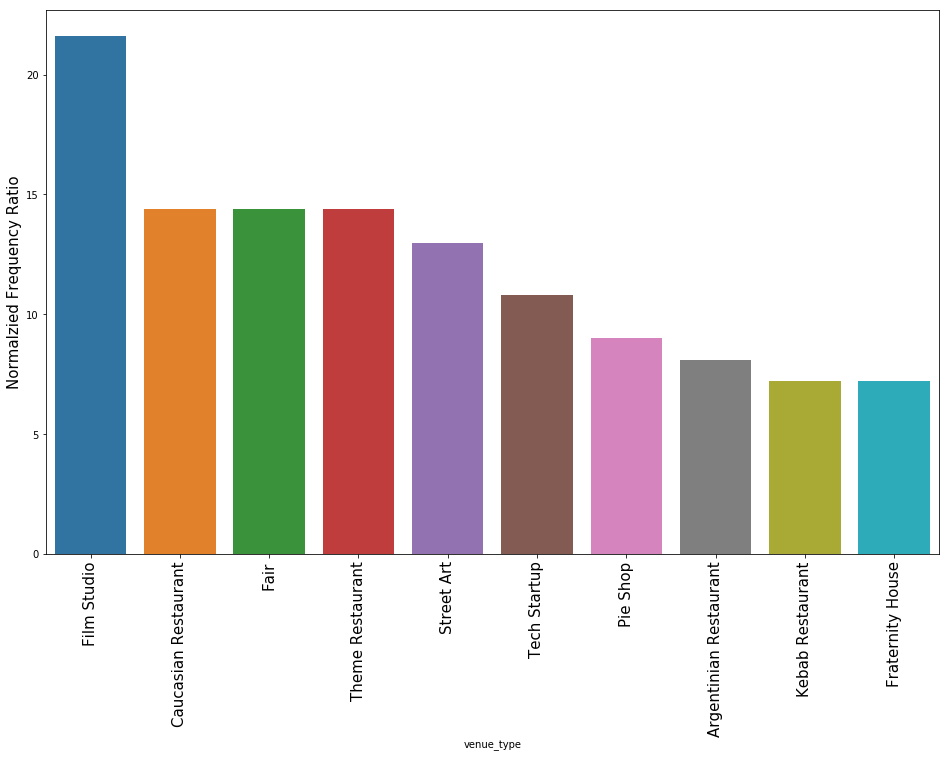

In [287]:
# frequency for all locations
cat_freq_all=pd.DataFrame(df_venues_grouped_no_Ice[df_ice_cream_merged_sum.iloc[:,range(6,670)].columns].mean())
cat_freq_all=cat_freq_all.sort_values(by=0, ascending=False)

# frequency for top locations locations
cat_freq_top=pd.DataFrame(df_ice_cream_merged_sum.iloc[range(0,top_30_pec_sampels),range(6,670)].mean())
cat_freq_top=cat_freq_top.sort_values(by=0, ascending=False)


cat_freq=cat_freq_top.merge(cat_freq_all,left_index=True, right_index=True)
cat_freq.drop(["Ice Cream Shop"],inplace=True)
cat_freq.reset_index(inplace=True)

nr_plot=10

cat_freq.columns=['venue_type','max','avg']
cat_freq.drop([1], inplace=True)
max_avg=cat_freq['max'].mean()
avg_avg=cat_freq['avg'].mean()

# normalize frequencies 
cat_freq['max']=cat_freq['max']/cat_freq['max'].mean()
cat_freq['avg']=cat_freq['avg']/cat_freq['avg'].mean()
# avoid 0 devision
cat_freq=cat_freq.loc[cat_freq['avg']>0]
cat_freq['ratio']=cat_freq['max']/cat_freq['avg']
cat_freq=cat_freq.sort_values(by='ratio', ascending=False)


# Plot venues vs. normalized ratio
#df_bar_plot=cat_freq[['venue_type','max']].head(nr_plot)
#df_bar_plot=df_bar_plot.append(pd.DataFrame(cat_freq[['venue_type','avg']].head(nr_plot).values, columns=['venue_type','max']))
# account for higher number of buisnesses
#df_bar_plot['max']=df_bar_plot['max']*buisness_ratio
#df_bar_plot=df_bar_plot.append(pd.DataFrame(cat_freq[['venue_type','max_adjusted']].head(nr_plot).values, columns=['venue_type','max']))
#df_bar_plot.columns=['venue_type','value']
#df_bar_plot['mess']='avg'
#df_bar_plot['mess'].iloc[range(0,nr_plot)]='max'
#df_bar_plot['mess'].iloc[range(2*nr_plot,3*nr_plot)]='max_adjusted'
#ax = sns.barplot(x="venue_type", y="value", hue="mess", data=df_bar_plot)

plt.figure(figsize=(16, 10))

ax = sns.barplot(x="venue_type", y="ratio", data=cat_freq.head(10))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_ylabel("Normalzied Frequency Ratio", fontsize=15)
cat_freq.reset_index(inplace=True, drop=True)


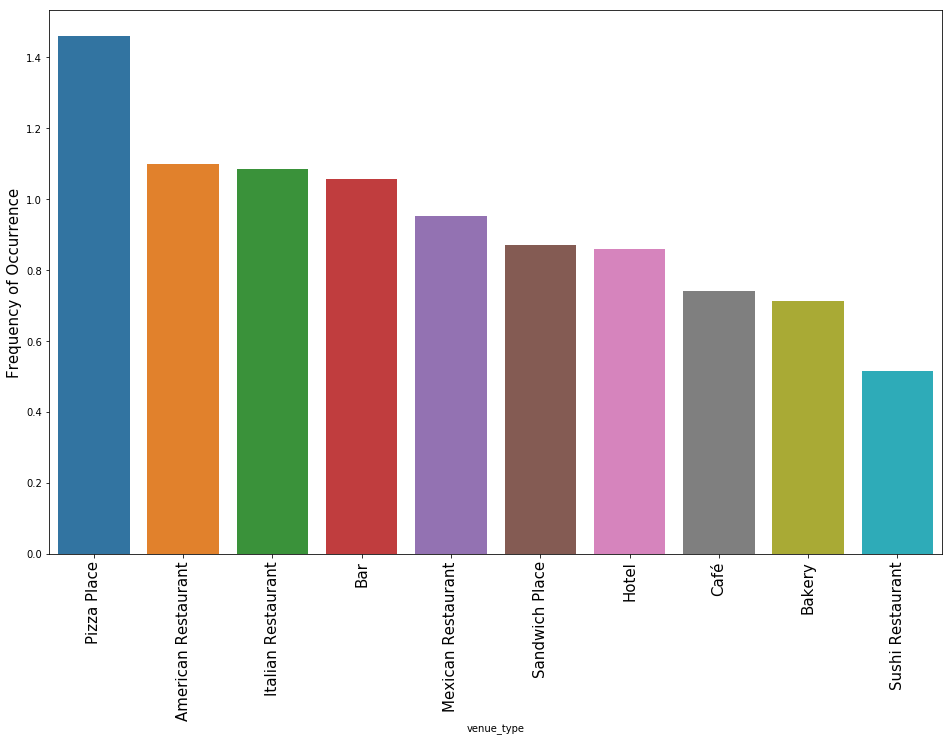

In [33]:
plt.figure(figsize=(16, 10))
df_bar_plot=cat_freq.sort_values(by='max', ascending=False).head(10)
df_bar_plot['max']=df_bar_plot['max']*max_avg
ax = sns.barplot(x="venue_type", y="max", data=df_bar_plot)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_ylabel("Frequency of Occurrence", fontsize=15)
cat_freq.reset_index(inplace=True, drop=True)


In [307]:
project.save_data("cat_freq.csv", cat_freq.to_csv(index=False), overwrite=True)
cat_freq.shape

(638, 4)

In [184]:
cat_freq_above10=cat_freq.loc[cat_freq['max']>0.2/max_avg,:]
cat_freq_above10['ratio']=cat_freq_above10['max']/cat_freq_above10['avg']
significant_venues=cat_freq_above10[abs(cat_freq_above10["ratio"]-1)>0.40]['venue_type'].values
len(significant_venues)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


32

In [350]:
df_significant_venues=pd.DataFrame(significant_venues)
df_significant_venues
project.save_data("df_significant_venues.csv", df_significant_venues.to_csv(index=False), overwrite=True)

{'file_name': 'df_significant_venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstone-donotdelete-pr-lrmdwfeelnvzph',
 'asset_id': 'd8599832-9a35-4142-86ce-66509673b7ea'}

In [491]:
my_file = project.get_file("df_significant_venues.csv")
df_significant_venues=pd.read_csv(my_file)
df_significant_venues.shape

(34, 1)

# Model Fitting

In [40]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import statistics
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns;


from sklearn.svm import SVR

In [34]:
#!conda install -c conda-forge imblearn=0.5.0 --yes
!pip install -U imbalanced-learn
#!pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

     |████████████████████████████████| 163kB 30.6MB/s eta 0:00:01
     |████████████████████████████████| 296kB 33.2MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 39.1MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement numpy>=1.16.4, but you'll have numpy 1.15.4 which is incompatible.
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
ERROR: autoai-libs 1.10.5 has requirement scikit-learn==0.20.3, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [35]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [36]:
my_file = project.get_file("df_venues_grouped_sum.csv")
df_venues_grouped_sum=pd.read_csv(my_file)
df_venues_grouped_sum.head()

,zip,ATM,Acai House,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit,emp,ap,est,venue_total
0,1001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9891,422470,473,6
1,1002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8482,299103,545,4
2,1003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,337,10380,21,5
3,1004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,213,5912,12,4
4,1005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1248,35287,94,2


In [37]:

my_file = project.get_file("df_ice_cream_merged_sum.csv")
df_ice_cream_merged_sum=pd.read_csv(my_file)
df_ice_cream_merged_sum.head()

,venue_id,zip,venue_likes,venue_photos,venue_tips,rating,ATM,Acai House,Accessories Store,Acupuncturist,...,Zoo,Zoo Exhibit,emp,ap,est,venue_total,Cheap,Expensive,Moderate,Very Expensive
0,4bc67b9abf29c9b6e5fef92a,90650,1,6,2,6.5,1,0,0,0,...,0,0,17078,852730,1118,14,1,0,0,0
1,4c4cde5be906c928f3930d3b,79761,6,1,1,7.4,0,0,0,0,...,0,0,16434,835680,1045,13,1,0,0,0
2,4b8879a6f964a5209efa31e3,55427,10,4,4,7.6,0,0,0,0,...,0,0,16860,790927,784,16,1,0,0,0
3,4ea837c8775bfe48033378fe,40206,91,100,38,9.0,0,0,0,0,...,0,0,11910,638234,689,35,1,0,0,0
4,4c33861c6f1fef3be592ec3d,46205,6,13,10,6.9,0,0,0,0,...,0,0,6529,265418,518,20,1,0,0,0


In [173]:
my_file = project.get_file("cat_freq.csv")
cat_freq=pd.read_csv(my_file)
cat_freq.shape

(638, 4)

In [254]:
def print_confusion_matrix (mat):
    print("Confusion Matrix:")
    print ("tn: {}({}%), fp: {}({})%)".format(mat[0][0],mat[0][0]/(mat[0][0]+mat[0][1]+mat[1][0]+mat[1][1]),mat[0][1],mat[0][1]/(mat[0][0]+mat[0][1]+mat[1][0]+mat[1][1])))
    print ("fn: {}({}%), tp: {}({})%)".format(mat[1][0],mat[1][0]/(mat[0][0]+mat[0][1]+mat[1][0]+mat[1][1]),mat[1][1],mat[1][1]/(mat[0][0]+mat[0][1]+mat[1][0]+mat[1][1])))


def classification_eval (y,y_h):
    print ("F1 score: {}".format(f1_score(y, y_h )))
    con_mat=confusion_matrix(y, y_h)
    print_confusion_matrix (con_mat)


### parameter fiting


In [293]:

#df_ice_cream_reduces[['emp','ap','est','venue_total','venue_likes']]=df_ice_cream_merged_sum.loc[:,['emp','ap','est','venue_total','venue_likes']]
#df_ice_cream_reduces[significant_venues]=df_ice_cream_merged_sum[significant_venues]
df_top_ice_cream=df_ice_cream_merged_sum.loc[df_ice_cream_merged_sum['venue_likes']>14,:]

df_top_ice_cream.drop(columns=['venue_likes','Cheap', 'venue_id', 'venue_photos', 'venue_tips', 'Expensive', 'Very Expensive', 'Moderate', 'rating'],inplace=True)

#print(df_top_ice_cream.shape)
#df_top_ice_cream.drop(columns=[venue_likes]).columns
df_venues_reduced=df_venues_grouped_sum[df_top_ice_cream.columns]
#df_venues_reduced=df_venues_reduced.loc[df_venues_grouped_sum["Ice Cream Shop"]==0]

#Downsampling 
idx = np.arange(df_venues_reduced.shape[0])
np.random.shuffle(idx)
df_venues_reduced=df_venues_reduced.iloc[idx[range(0,df_top_ice_cream.shape[0])],:]


df_top_ice_cream['label']=1
df_venues_reduced['label']=0

print(df_top_ice_cream.shape)
print(df_venues_reduced.shape)

X=df_top_ice_cream
X=X.append(df_venues_reduced)
y=X[['label']]
X.drop(columns=['label'], inplace=True)


#training/test split
X_train, X_test, y_train, y_test, = train_test_split( X, y, test_size=0.3, random_state=0)
y_train=np.ravel(y_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)




/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(440, 670)
(440, 670)


In [177]:
cat_freq.loc[cat_freq['avg']>0,:].shape

(638, 5)

In [249]:
LogRg = LogisticRegression(random_state=0, solver='liblinear')

In [183]:

#cat_freq=cat_freq.loc[cat_freq['avg']>0,:]
cat_freq['ratio']=cat_freq.loc[:,'max']/cat_freq.loc[:,'avg']
result_list=[]
result_dim=[]
freq_list=0.05*np.arange(10)
sig_list=0.05*np.arange(10)
for freq in freq_list:
    temp=[]
    temp_dim=[]
    cat_freq_above10=cat_freq.loc[cat_freq['max']>=(freq/max_avg),:]
    for sig in sig_list:
        significant_venues=cat_freq_above10.loc[abs(cat_freq_above10["ratio"]-1)>=sig,'venue_type'].to_list()
        #significant_venues.extend(['emp','ap','est','venue_total'])
        significant_venues.extend(['emp','ap','est'])
        scaler = preprocessing.StandardScaler().fit(X_train[significant_venues])
        X_reduce = scaler.transform(X_train[significant_venues])
        sco=cross_val_score(LogRg, X_reduce, y_train, cv=3, scoring='f1_macro')
        temp.append(sco.mean())
        temp_dim.append(len(significant_venues))
    result_list.append(temp)
    result_dim.append(temp_dim)
    
df_dim=pd.DataFrame(result_dim, index=[ '%.2f' % elem for elem in freq_list ])
df_dim.columns= [ '%.2f' % elem for elem in sig_list ]
print(df_dim)    
    
df_result=pd.DataFrame(result_list, index=[ '%.2f' % elem for elem in freq_list ])
df_result.columns= [ '%.2f' % elem for elem in sig_list ]
df_result

      0.00  0.05  0.10  0.15  0.20  0.25  0.30  0.35  0.40  0.45
0.00   641   611   583   558   529   511   487   452   440   425
0.05   155   139   126   117   104    98    84    80    77    71
0.10    91    83    77    71    64    59    51    49    47    44
0.15    72    65    61    57    51    47    41    40    39    37
0.20    53    46    45    42    39    37    31    30    29    28
0.25    40    33    32    29    27    26    22    21    20    20
0.30    34    28    27    24    22    21    17    16    15    15
0.35    27    21    20    18    17    16    12    12    12    12
0.40    23    19    18    16    15    15    11    11    11    11
0.45    19    16    15    13    12    12     8     8     8     8


,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45
0.00,0.739330,0.756951,0.750926,0.733556,0.753896,0.782075,0.780261,0.766796,0.771491,0.774780
0.05,0.762697,0.781085,0.786143,0.779408,0.782675,0.787561,0.801598,0.803273,0.802961,0.803029
0.10,0.793807,0.813936,0.804013,0.784295,0.792113,0.800018,0.811326,0.816247,0.812725,0.812716
0.15,0.793889,0.794004,0.790889,0.794018,0.801878,0.803340,0.824651,0.826243,0.812470,0.815924
0.20,0.805673,0.801001,0.809024,0.812360,0.809086,0.820123,0.833243,0.834766,0.828157,0.828167
0.25,0.815482,0.823916,0.828564,0.840096,0.840008,0.835187,0.844720,0.839813,0.834708,0.834708
0.30,0.818430,0.825658,0.833390,0.835160,0.831773,0.841676,0.832955,0.829690,0.821278,0.821278
0.35,0.810459,0.828959,0.828654,0.821968,0.810788,0.812462,0.808599,0.808599,0.808599,0.808599
0.40,0.823815,0.827287,0.827115,0.823667,0.815627,0.815627,0.811602,0.811602,0.811602,0.811602
0.45,0.828898,0.825784,0.827372,0.826988,0.833703,0.833703,0.804763,0.804763,0.804763,0.804763


Text(0.5, 1.0, 'F1 Score')

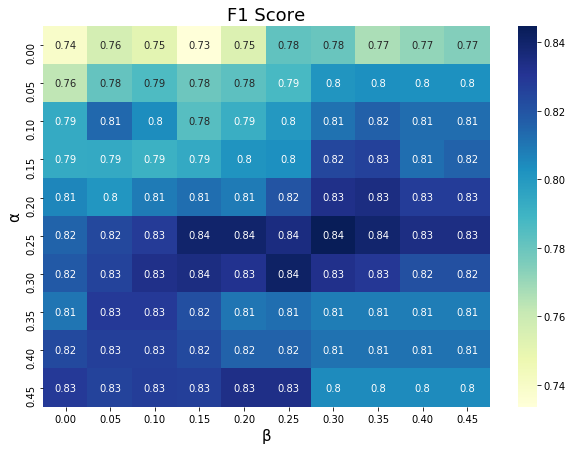

In [192]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(df_result,  cmap="YlGnBu",  annot=True)
ax.set_ylabel("α", fontsize=15)
ax.set_xlabel("β", fontsize=15)
plt.title('F1 Score', fontsize=18)

Text(0.5, 1.0, 'Number of Venues selected as Features')

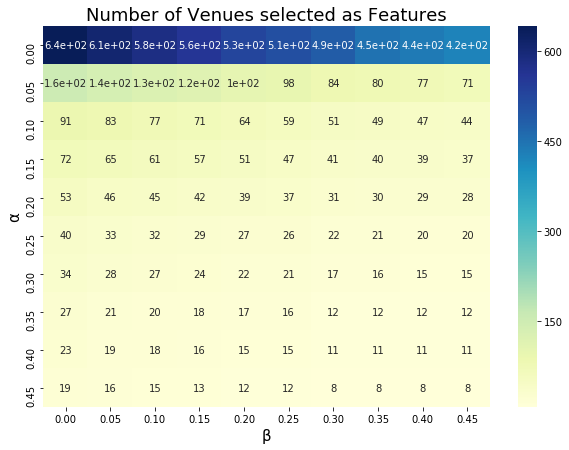

In [193]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(df_dim, cmap="YlGnBu", annot=True)
ax.set_ylabel("α", fontsize=15)
ax.set_xlabel("β", fontsize=15)
plt.title('Number of Venues selected as Features', fontsize=18)

In [294]:
cat_freq_above10=cat_freq.loc[cat_freq['max']>(0.25/max_avg),:]
significant_venues=cat_freq_above10.loc[abs(cat_freq_above10["ratio"]-1)>0.30,'venue_type'].to_list()
significant_venues.extend(['emp','ap','est'])
#significant_venues=['venue_total']

scaler = preprocessing.StandardScaler().fit(X_train[significant_venues])
X_reduce = scaler.transform(X_train[significant_venues])
X_test_reduce = scaler.transform(X_test[significant_venues])
sco=cross_val_score(LogRg, X_reduce, y_train, cv=3, scoring='f1_macro')
sco.mean()


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8202455345021424

Text(0.5, 1.0, 'Properties of Venue Features')

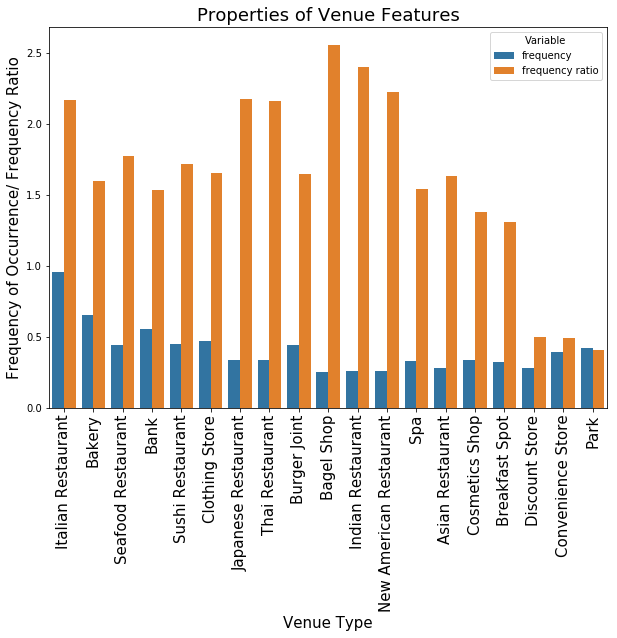

In [243]:
cat_plot=cat_freq_above10.set_index('venue_type').loc[cat_freq_above10.loc[abs(cat_freq_above10["ratio"]-1)>0.30,'venue_type'].to_list(),:]



df_bar_plot=cat_plot.reset_index().loc[:,['venue_type', 'max']]
df_bar_plot['max']=df_bar_plot['max']*max_avg
df_bar_plot=df_bar_plot.append(pd.DataFrame(cat_plot.reset_index().loc[:,['venue_type', 'ratio']].values, columns=['venue_type','max']))

df_bar_plot
#df_bar_plot=df_bar_plot.append(pd.DataFrame(cat_freq[['venue_type','max_adjusted']].head(nr_plot).values, columns=['venue_type','max']))
df_bar_plot.columns=['venue_type','value']
df_bar_plot['Variable']='frequency ratio'
df_bar_plot['Variable'].iloc[range(0,cat_plot.shape[0])]='frequency'
df_bar_plot['Variable'].iloc[range(0,cat_plot.shape[0])]='frequency'
plt.figure(figsize=(10, 7))

ax = sns.barplot(x="venue_type", y="value", hue="Variable", data=df_bar_plot)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_ylabel("Frequency of Occurrence/ Frequency Ratio", fontsize=15)
ax.set_xlabel("Venue Type", fontsize=15)
plt.title('Properties of Venue Features', fontsize=18)

In [295]:
LogRg.fit( X_reduce, y_train)
y_pred_LogRg=LogRg.predict(X_reduce)
print("Training Set")
classification_eval(y_train, y_pred_LogRg )
y_pred_LogRg=LogRg.predict(X_test_reduce)
print("Test Set")
classification_eval(y_test, y_pred_LogRg )


X_test_reduce
y_pred_LogRg_prob=LogRg.predict_proba(X_test_reduce)



Training Set
F1 score: 0.8231173380035027
Confusion Matrix:
tn: 280(0.45454545454545453%), fp: 30(0.048701298701298704)%)
fn: 71(0.11525974025974026%), tp: 235(0.3814935064935065)%)
Test Set
F1 score: 0.8412698412698412
Confusion Matrix:
tn: 118(0.44696969696969696%), fp: 12(0.045454545454545456)%)
fn: 28(0.10606060606060606%), tp: 106(0.4015151515151515)%)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [134]:
def class_error (act_label,pre_label):
    err_list=[]
    for act, pre in zip(act_label,pre_label):
        if(act==1 and pre==1):
            err_list.append('true positive')
        elif(act==1 and pre==0):
            err_list.append('false negative')
        elif(act==0 and pre==0):
            err_list.append('true negative')
        else:
            err_list.append('false positive')
    return err_list      

In [296]:
df_vis=y_test.reset_index(drop=True)
df_vis['prd']=y_pred_LogRg
df_vis=df_vis.merge(pd.DataFrame(y_pred_LogRg_prob),left_index=True, right_index=True)

In [297]:
df_vis['errorType']=class_error (df_vis['label'],df_vis['prd'])
df_vis.columns=['label', 'prd', '0', '1', 'errorType']
df_vis.head(10)

,label,prd,0,1,errorType
0,1,0,0.717981,0.282019,false negative
1,1,1,0.029401,0.970599,true positive
2,0,0,0.858149,0.141851,true negative
3,1,1,0.464181,0.535819,true positive
4,0,0,0.863557,0.136443,true negative
5,0,0,0.863563,0.136437,true negative
6,0,0,0.694433,0.305567,true negative
7,0,0,0.814084,0.185916,true negative
8,1,1,0.138956,0.861044,true positive
9,1,1,0.000270,0.999730,true positive


Text(0.5, 0, 'Classification Outcome')

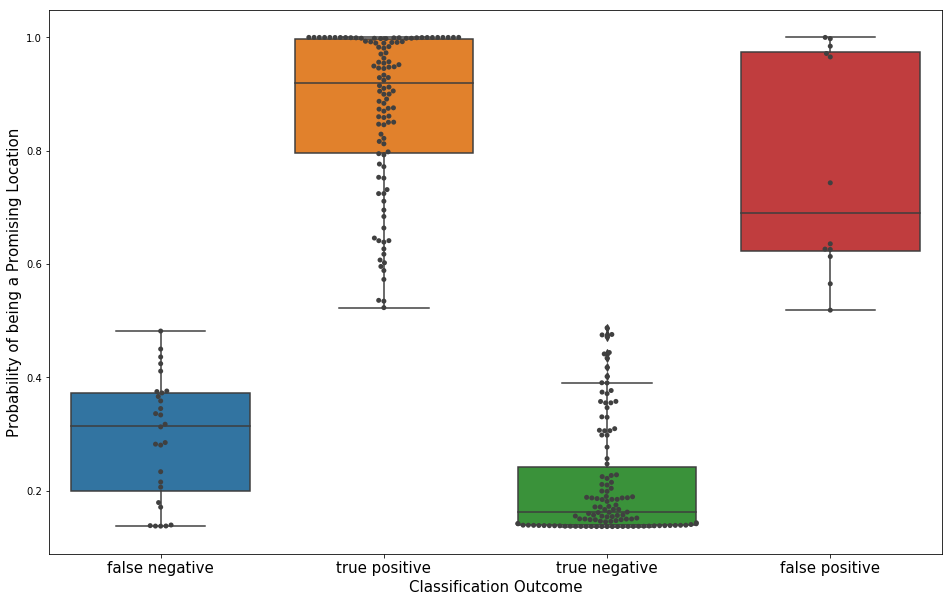

In [303]:
plt.figure(figsize=(16, 10))
ax = sns.boxplot(x="errorType", y='1', data=df_vis)
ax = sns.swarmplot(x="errorType", y="1", data=df_vis, color=".25")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_ylabel("Probability of being a Promising Location", fontsize=15)
ax.set_xlabel("Classification Outcome", fontsize=15)


In [315]:
X_test_reduce = scaler.transform(df_venues_grouped_sum[significant_venues])

In [316]:
y_pred_LogRg_prob=LogRg.predict_proba(X_test_reduce)

In [317]:
candidate_prob=pd.DataFrame(y_pred_LogRg_prob,columns=['0','1'])
candidate_prob['zip']=df_venues_grouped_sum['zip']
candidate_prob.sort_values(by='1', ascending=False, inplace=True)

plot_candidates=candidate_prob.head(10).merge(df_geo_data_reduced, on='zip')


In [304]:
!pip install folium

     |████████████████████████████████| 102kB 10.2MB/s ta 0:00:01


In [311]:
import folium

In [312]:
# US latitude and longitude values
latitude = 37.0902
longitude = -95.7129

In [314]:
# create map and display it
us_map = folium.Map(location=[latitude, longitude], zoom_start=4)

locations = folium.map.FeatureGroup()

# loop through the most promising locations and add each to the locations feature group
for lat, lng, in zip(plot_candidates['Latitude'], plot_candidates['Longitude']):
    locations.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
us_map.add_child(locations)